In [1]:
import os
import os.path
import shutil
import tensorflow as tf
from tensorboard.plugins.beholder import Beholder
import pickle
import numpy as np
import math

In [2]:
# from keras.datasets import mnist
# (X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = pickle.load(open("X_train.pickle", "rb"))
y_train = pickle.load(open("y_train.pickle", "rb"))
X_test = pickle.load(open("X_test.pickle", "rb"))
y_test = pickle.load(open("y_test.pickle", "rb"))


X_train = X_train.astype('float32')
y_train = y_train.astype('float32')
X_test = X_test.astype('float32')
y_test = y_test.astype('float32')

In [4]:
one_hot = {0:[1, 0],
           1:[0, 1]}

In [5]:
# one_hot = {0: [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#            1: [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
#            2: [0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
#            3: [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
#            4: [0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
#            5: [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
#            6: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
#            7: [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
#            8: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
#            9: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]}

In [6]:
# (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train.shape

(2000, 299, 299, 3)

In [7]:
import matplotlib.pyplot as plt
plt.imshow(X_train[0])
plt.show()


<Figure size 640x480 with 1 Axes>

In [8]:
y_labels_test = []
y_labels_train = []
for y in y_test:
    y_labels_test.append(one_hot[y])
for y in y_train:
    y_labels_train.append(one_hot[y])

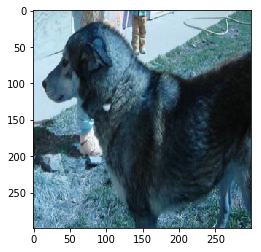

[0, 1]


In [17]:
import matplotlib.pyplot as plt
plt.imshow((X_test[3]))

plt.show()
print(y_labels_test[3])

In [19]:
LOGDIR = 'fourteen'
BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-4

In [20]:
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [21]:
X_train.dtype

dtype('float32')

In [17]:
import tensorflow_hub as hub

In [23]:
def network(x):
    x_image = tf.reshape(x, [-1, 299, 299, 3])
    
    tf.summary.image('input', x_image, 3)

    image_module = hub.Module("https://tfhub.dev/google/imagenet/inception_v3/feature_vector/1")  
    features = image_module(x)
    
    layer = tf.layers.dense(inputs=features, units=2, activation=None)
    return layer

tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
    
with tf.name_scope("inputs"):
    x = tf.placeholder(tf.float32, shape=[None, 299, 299, 3], name="x")

    y = tf.placeholder(tf.float32, shape=[None, 2], name="labels")
              
logits = network(x)
        
with tf.name_scope("xent"):
    xent = tf.reduce_mean(
                    tf.nn.softmax_cross_entropy_with_logits_v2(
                    logits=logits, labels=y), name="xent")
    tf.summary.scalar("xent", xent)

with tf.name_scope("train"):
    train_step = tf.train.AdamOptimizer(LR, name='Adam').minimize(xent)

with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    tf.summary.scalar("accuracy", accuracy)

with tf.name_scope("accuracy_val"):
    correct_prediction_val = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
    accuracy_val = tf.reduce_mean(tf.cast(correct_prediction_val, tf.float32))
    tf.summary.scalar("accuracy_val", accuracy_val)

summ = tf.summary.merge_all()

saver = tf.train.Saver()

with tf.Session(config=config) as sess:
        
    from tensorboard.plugins.beholder import Beholder
    beholder = Beholder(LOGDIR)
    
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(LOGDIR)
    writer.add_graph(sess.graph)

    for i in range(EPOCHS):
        print(i)

#         [train_accuracy, s] = sess.run([accuracy, summ], feed_dict={x: X_train[0:700], y: y_labels_train[0:700]})
#         [test_accuracy, s] = sess.run([accuracy_val, summ], feed_dict={x: X_test[0:700], y: y_labels_test[0:700]})
#         writer.add_summary(s, i)
#             sess.run(train_step, feed_dict={x: X_train, y: y_labels_train})
            
        for j in range(math.ceil(len(X_train) / BATCH_SIZE)):
            batch_x, batch_y = next_batch(num = BATCH_SIZE, data = X_train, labels = y_labels_train)
            sess.run(train_step, feed_dict={x: batch_x, y: batch_y})
        beholder.update(session=sess)

    export_path =  './savedmodel14'
    builder = tf.saved_model.builder.SavedModelBuilder(export_path)

    tensor_info_x = tf.saved_model.utils.build_tensor_info(x)
    tensor_info_y = tf.saved_model.utils.build_tensor_info(logits)

    prediction_signature = (
      tf.saved_model.signature_def_utils.build_signature_def(
          inputs={'x_input': tensor_info_x},
          outputs={'y_output': tensor_info_y},
          method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME))

    builder.add_meta_graph_and_variables(
      sess, [tf.saved_model.tag_constants.SERVING],
      signature_def_map={
          tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
              prediction_signature 
      },
      )
    builder.save()
    sess.close()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./savedmodel14\saved_model.pb


In [ ]:
from IPython.display import display_html
def restartkernel() :
    display_html("<script>Jupyter.notebook.kernel.restart()</script>",raw=True)
restartkernel()

In [ ]:
# from keras.datasets import mnist
# (X_train, y_train), (X_test, y_test) = mnist.load_data()

In [1]:
import pickle
# X_train = pickle.load(open("X_train.pickle", "rb"))
# y_train = pickle.load(open("y_train.pickle", "rb"))
X_test = pickle.load(open("X_test.pickle", "rb"))
y_test = pickle.load(open("y_test.pickle", "rb"))


# X_train = X_train.astype('float32')
# y_train = y_train.astype('float32')
# X_test = X_test.astype('float32')
# y_test = y_test.astype('float32')

In [140]:
img = []
img.append(cv2.imread("test.jpg"))
img.append(cv2.imread("test1.jpg"))
img[0] = cv2.resize(img[0], (299, 299))
img[1] = cv2.resize(img[1], (299, 299))
img[0] = img[0]/255
img[1] = img[1]/255

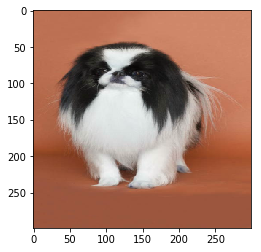

In [141]:
plt.imshow(img[0])

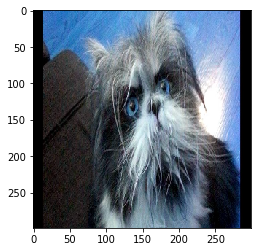

In [142]:
plt.imshow(img[1])

In [143]:
img = np.array(img)

In [148]:
img.shape

(2, 299, 299, 3)

In [149]:
import tensorflow as tf
with tf.Session() as sess:
    signature_key = tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY
    input_key = 'x_input'
    output_key = 'y_output'

    export_path =  './savedmodel14'
    meta_graph_def = tf.saved_model.loader.load(
               sess,
              [tf.saved_model.tag_constants.SERVING],
              export_path)
    signature = meta_graph_def.signature_def

    x_tensor_name = signature[signature_key].inputs[input_key].name
    y_tensor_name = signature[signature_key].outputs[output_key].name

    x = sess.graph.get_tensor_by_name(x_tensor_name)
    y = sess.graph.get_tensor_by_name(y_tensor_name)

    y_out = sess.run(y, {x: img})

INFO:tensorflow:Restoring parameters from ./savedmodel14\variables\variables


In [150]:
import numpy as np
predicted_values = []
for i in range(len(y_out)):
    index_max = np.argmax(y_out[i])
    predicted_values.append(index_max)

DOG


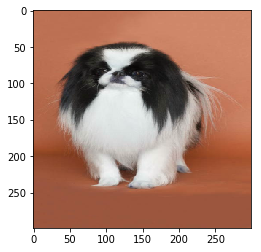

CAT


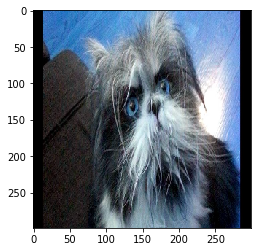

In [151]:
import matplotlib.pyplot as plt
import numpy as np
for i in range(2):
    plt.imshow(img[i])
    if predicted_values[i] == 1:
        print("DOG")
    else:
        print("CAT")
    plt.show()

In [6]:
def classification_metrics(actual, pred, msg):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(actual, pred)
    import seaborn as sns     

    plt.figure()
    ax= plt.subplot()
    sns.heatmap(cm, annot = True, fmt = 'g')

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels') 
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']) 
    ax.yaxis.set_ticklabels(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])   
    plt.show()       
    sensitivity = cm[1][1]/(cm[1][0] + cm[1][1])
    specifity = cm[0][0]/(cm[0][0] + cm[0][1])
    accuracy = (cm[0][0] + cm[1][1]) / np.sum(cm)
    
    print(msg, '\n')
    print('accuracy:    ', round(accuracy,2), 
      '\nsensitivity: ', round(sensitivity,2), 
      '\nspecifity:   ', round(specifity,2))
#     from sklearn.metrics import classification_report
#     print(classification_report(actual, pred))
              


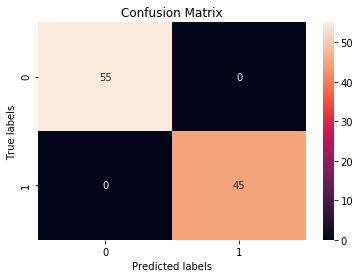

 

accuracy:     1.0 
sensitivity:  1.0 
specifity:    1.0


In [7]:
classification_metrics((y_test[0:100]).astype(int), predicted_values, msg = '')